In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
X_train = pd.read_csv("../data/raw/X_train.csv", sep=",",index_col=0)
Y_train = pd.read_csv("../data/raw/Y_train.csv", sep=",",index_col=0)

In [2]:
# NORMALISATION DU TEXTE

from unidecode import unidecode
# D'abord on normalise le texte pour éviter certains pb lors de l'analyse de doublong (sensibilité à la case, encodage, espace en début/fin ...)
def clean_text(text):
    if isinstance(text, str):            # Si le texte est une chaîne de caractères,
        text = unidecode(text)          # Remplace les accents par des lettres sans accent
        text = text.lower()               # Met le texte en minuscule
        text = text.strip()              # supprime les espaces en début/fin de chaine
        text = ' '.join(text.split())    # supprime les espaces inutiles
        return text
    return text
    
X_train["designation"] = X_train["designation"].map(clean_text)
X_train["description"] = X_train['description'].map(clean_text)

# SUPPRESSION DES DOUBLONS EN COLONNE

# Avant de concaténer Designation et Description, on vérifie qu'il n'y a pas la même chose dans ces deux colonnes
nb_duplicates = (X_train["designation"] == X_train["description"]).sum()
print("Il y a",nb_duplicates,"lignes où designation et description contiennent les mêmes informations")

# On remplace alors la description par une chaine de caractère vide pour préparer la concaténation
X_train.loc[X_train["designation"] == X_train["description"], "description"] = ""

# On vérifie que le nettoyage a fonctionné
nb_duplicates_ac = (X_train["designation"] == X_train["description"]).sum()
print("Il y a",nb_duplicates_ac,"lignes où designation et description contiennent les mêmes informations après nettoyage")

Il y a 865 lignes où designation et description contiennent les mêmes informations
Il y a 0 lignes où designation et description contiennent les mêmes informations après nettoyage


In [3]:
# CONCATENATION DES COLONNEs DESIGNATION ET DESCRIPTION

print("Nombre de NaN dans la colonne designation:", X_train["designation"].isna().sum())
print("Nombre de NaN dans la colonne description:", X_train["description"].isna().sum(),"\n")

# On remplace les NaN de la colonne "description" par une chaine vide pour que la concaténation fonctionne
# et concatène "designation" et "description" dans une nouvelle colonne full description
# puis on supprime les éventuels espace de fin inutile
X_train["text"] = X_train[["designation", "description"]].fillna("").agg(' '.join, axis=1)
X_train["text"] = X_train["text"].str.strip()

# Suppression des colonnes inutiles
X_train = X_train.drop(columns=['designation','description'])
display(X_train.head(5))

Nombre de NaN dans la colonne designation: 0
Nombre de NaN dans la colonne description: 29800 



,productid,imageid,text
0,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...
1,436067568,1008141237,journal des arts (le) ndeg 133 du 28/09/2001 -...
2,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...
3,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...
4,278535884,1077757786,la guerre des tuques luc a des id&eacute;es de...


In [4]:
# On regarde si on a des doublons
nb_duplicated_text = X_train['text'].duplicated().sum()
print("il existe", nb_duplicated_text, "doublons de texte")

# Suppression des doublons en fonction de la colonne fusionnée
X_train = X_train.drop_duplicates(subset=['text'])
print("suppression des",nb_duplicated_text,"doublons")

il existe 1453 doublons de texte
suppression des 1453 doublons


On remarque en étudiant le contenu du dataset visuellement que celui-ci semble contenir:
* des balise html 
* des entités html (&amp, &nbsp,&lt, &gt ...)

Ces balises et ces entités ne sont pas toujours bien formées (ex: < br >, & nbsp ...)


In [5]:
# traitement des entités html (type &amp, &quot, etc)

import html

X_train["text"] = X_train["text"].apply(html.unescape)

# On va essayer d'identifier les cas les plus fréquents d'entitée html mal formée
df_html = X_train["text"].str.extract(r"(&\s*\w+\s*;)").dropna()
display(df_html.value_counts().head(30))

# Dictionnaire des entités malformées à corriger
html_entities = {
    "& amp;": "&amp;",
    "& nbsp;": "&nbsp;",
    "& lt;": "&lt;",
    "& gt;": "&gt;",
    "& nbsp ;": "&nbsp;",
    "& amp ;": "&amp;",
    "& gt ;": "&gt;",
    "& quot;": "&quot;"
}

# Remplacer toutes les entités malformées en une seule passe
for incorrect, correct in html_entities.items():
    X_train["text"] = X_train["text"].str.replace(incorrect, correct, regex=False)

# on unescape de nouveau les entités pour gérer les cas corrigés
X_train["text"] = X_train["text"].apply(html.unescape)

0          
& amp;         960
& nbsp;        354
& lt;          100
& gt;           81
& nbsp ;        18
& amp ;          8
&apos;           4
& patcher ;      2
& gt ;           1
& play ;         1
& quot;          1
&quot;           1
Name: count, dtype: int64

In [6]:
# TRAITEMENT DES BALISES HTML (type <b>, </p>, etc)

# Importation de la bibliothèque "Regular Expression"
import re     

# Fonction qui identifie tout ce qui est délimité par < >
def extraction_balises(texte):
    return re.findall(r"<[^>]+>", str(texte))        

# Création d'une liste d'éléments uniques
balises = set()                                   
X_train["text"].apply(lambda x: balises.update(extraction_balises(x)))

print("Nous avons identifié",len(balises),"balises html uniques présentent dans les descriptions produit")

Nous avons identifié 1076 balises html uniques présentent dans les descriptions produit


En jettant consultant la liste des balises identifiées, on observe 
* qu'il n'y a pas que des balises HTML. Il y a également beaucoup de texte délimité par des doubles chevrons, par exemple : << brouillard >>, <>, ou encore <>
* qu'il y a des balises html mal formée < br >, < /p>
* qu'il y a des commentaires html <!-- -->

Si on veut nettoyer efficacement en limitant la perte d'information, je pense qu'il faut d'abord gérer à part les cas comme << brouillard >> en supprimant les doubles chevrons et en conservant le texte.
puis utiliser une regex assez large pour supprimer tout contenu compris entre 2 chevrons.

In [7]:
# suppression des doubles chevrons
X_train["text"] = X_train["text"].str.replace("<<", "").str.replace(">>", "")

# nettoye le caractère mal interprétés
X_train["text"] = X_train["text"].str.replace("?", " ")

# on supprime les balises html quelles soient bien ou mal formées
X_train['text'] = X_train['text'].str.replace(r'<[^>]*>', ' ', regex=True)

# Supprimer la ponctuation
X_train['text'] = X_train['text'].str.replace(r'[^a-z0-9\s]', ' ', regex=True)

# on clean de nouveau après les manipulations
X_train["text"] = X_train['text'].map(clean_text)

# on vérifie qu'il n'y a plus de balise html
balises2 = set()                                   
X_train["text"].apply(lambda x: balises2.update(extraction_balises(x)))

print("Nous avons identifier",len(balises2),"balises html uniques restant")

Nous avons identifier 0 balises html uniques restant


In [8]:
duplicated = X_train["text"].duplicated().sum()

print("Après traitement du html on se retrouve avec",duplicated,"doublon")

X_train = X_train.drop_duplicates(subset=['text'])

Après traitement du html on se retrouve avec 60 doublon


In [9]:
from langdetect import detect, detect_langs
import pandas as pd
import time

def identifier_langue(texte):
  return detect(str(texte))

# Détection des langues+
print("start: apply")
start = time.time()
X_train["lang"] = X_train["text"].apply(identifier_langue)
end = time.time()
print("temps d'exécution:",end-start)

X_train['nb_car'] = X_train['text'].str.len()

start: apply
temps d'exécution: 332.7748444080353


In [10]:
# sauvegarde du dataframe clean dans un fichier
X_train.to_csv("../data/interim/X_train.csv", index=True)
Y_train.loc[Y_train.index.isin(X_train.index)].to_csv("../data/interim/Y_train.csv", index=True)

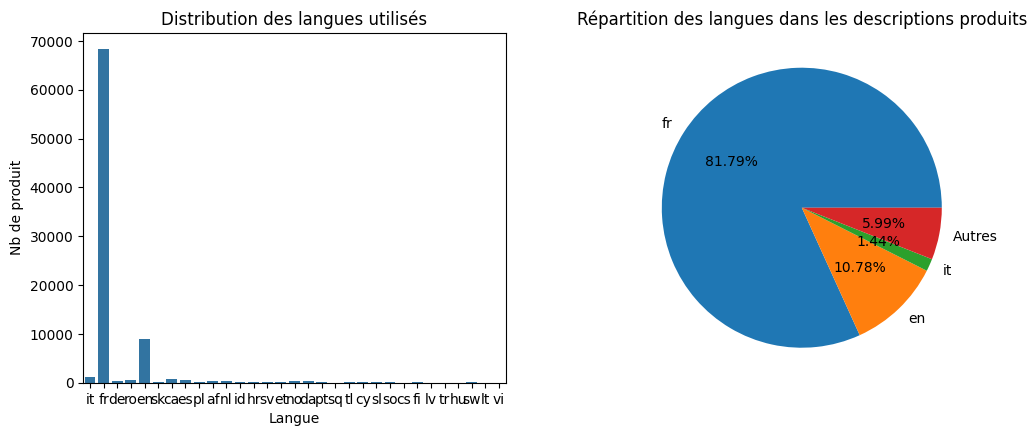

In [117]:
X = X_train["lang"]#[X_train["nb_car"] > 50]["lang"]

# répartition des effectifs par langue utilisé dans la description
plt.figure(figsize=(12,10))
plt.subplot(221)
sns.countplot(x = X)
plt.xlabel("Langue")
plt.ylabel("Nb de produit")
plt.title("Distribution des langues utilisés")

plt.subplot(222)

# On regroupe les langues trop peu présentes dans une même catégorie 
# pour conserver un affichage clair sur le graphe
counts =X.value_counts()
seuil = 0.01 * counts.sum()

# Séparer les grandes valeurs des petites
lang_counts = counts[counts >= seuil]
lang_counts["Autres"] = counts[counts < seuil].sum()

plt.pie(lang_counts, labels =lang_counts.index, autopct = lambda x: str(round(x, 2)) + '%',)
plt.title("Répartition des langues dans les descriptions produits")

plt.show()

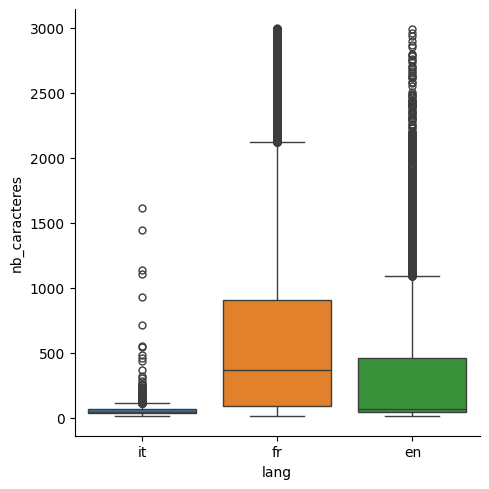

In [119]:
#X_train[X_train["lang"] =="fr"]["nb_car"].describe()

x = X_train[X_train["lang"].isin(["fr","en","it"])]
x = x[x["nb_car"] < 3000]

sns.catplot (x = "lang", y = "nb_car", hue = "lang", kind = "box", data = x)

La proportion de descriptions produits détectées comme étant dans une autre langue de le français est importantes. 
Cela est surement du au fait que ces mêmes description sont très majoritairement des descriptions courtes ce qui ne permet pas forcément à la librairie de correctement détecter la langue.

On remarque que certains descriptif en français contiennent également des mots anglais faisant référence à des marques, des noms de films... qui ne doivent pas être traduit 

ex: 
- cartes **magic** ...
- véhicule miniature - **star wars** rogue one...
- tournevis de demontage manette **ps4** **sony** **playstation** 4 ps4...
- figurine pop **game of thrones** ...
- Jeu vidéo **resident Evil**...  

En fonction de la longueur de la description celle-ci peut être identifié comme du français ou de l'anglais.
Est ce qu'il ne serait pas plus cohérent de tout normaliser en français ?


In [112]:
x[x["lang"] == "en"].to_csv("../data/interim/X_en.csv")
x[x["lang"] == "it"].to_csv("../data/interim/X_it.csv")

In [130]:
import spacy

nlp = spacy.load("fr_core_news_lg")  # Modèle NER spécialisé en français

text = "Le casque Sony est idéal pour Call of Duty."
doc = nlp(text)

for ent in doc.ents:
    print(ent.text, ent.label_)  

Sony ORG
Call of Duty MISC


In [ ]:
import spacy
nlp = spacy.load("xx_ent_wiki_sm")  # Modèle NER multilingue
#nlp = spacy.load("fr_core_news_lg")  # Modèle NER spécialisé en français

# ORG (Marques)
# PRODUCT (Produits, jeux vidéo, films)
# WORK_OF_ART (Films, livres)
#PERSON (Si pertinent, pour les créateurs de marque)

entities = ["ORG", "PRODUCT", "WORK_OF_ART", "MISC", "CATEGORY"]
entities = ["ORG"]

org = set()

for text in X_train["text"].head(5000):
    #text = "Ce téléphone Samsung est inspiré du film The Matrix."
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in entities:
            org.add(ent.text)

display(org)